In [1]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt

import itertools
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [2]:
df = pd.read_csv('../data/real_data.csv', parse_dates=['Date'], dayfirst=True)

C:\Users\duong\AppData\Local\Temp\ipykernel_11916\23663346.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv('../data/real_data.csv', parse_dates=['Date'], dayfirst=True)


In [3]:
df.isna().sum()

Date                       0
daily_cases                0
retail_and_recreation      0
grocery_and_pharmacy       0
parks_change               0
transit_stations           0
workplaces               361
residential_change         0
dtype: int64

In [4]:
df.dtypes

Date                     datetime64[ns]
daily_cases                       int64
retail_and_recreation             int64
grocery_and_pharmacy              int64
parks_change                      int64
transit_stations                  int64
workplaces                      float64
residential_change                int64
dtype: object

In [5]:
df.describe()

,Date,daily_cases,retail_and_recreation,grocery_and_pharmacy,parks_change,transit_stations,workplaces,residential_change
count,502,502.000000,502.000000,502.000000,502.000000,502.000000,141.000000,502.000000
mean,2022-02-06 12:00:00.000000256,2035.029880,-30.633466,-13.812749,-23.523904,-43.492032,-35.390071,10.507968
min,2021-06-01 00:00:00,1.000000,-87.000000,-67.000000,-83.000000,-89.000000,-84.000000,-1.000000
25%,2021-10-04 06:00:00,73.000000,-42.750000,-19.000000,-36.000000,-56.000000,-60.000000,5.000000
50%,2022-02-06 12:00:00,204.500000,-27.000000,-9.000000,-23.000000,-47.500000,-34.000000,7.000000
75%,2022-06-11 18:00:00,1005.250000,-13.000000,0.000000,-4.000000,-22.000000,-13.000000,11.000000
max,2022-10-15 00:00:00,30525.000000,13.000000,22.000000,38.000000,6.000000,2.000000,43.000000
std,NaN,5312.121989,24.250792,20.157583,26.232996,23.331999,23.344860,8.984292


## Feature engineering

In [6]:
# Assuming 'df' is defined and accessible in the current cell
df['year'] = df['Date'].dt.year
df['month'] = df['Date'].dt.month
df['day'] = df['Date'].dt.day
df.tail(5)

,Date,daily_cases,retail_and_recreation,grocery_and_pharmacy,parks_change,transit_stations,workplaces,residential_change,year,month,day
497,2022-10-11,53,-7,7,0,-13,NaN,6,2022,10,11
498,2022-10-12,30,1,-2,-10,-18,NaN,5,2022,10,12
499,2022-10-13,46,13,-1,-5,2,NaN,2,2022,10,13
500,2022-10-14,6,-2,7,-4,-12,NaN,4,2022,10,14
501,2022-10-15,6,9,18,20,-7,NaN,5,2022,10,15


In [7]:
df['lag_1'] = df['daily_cases'].shift(1)
df['lag_2'] = df['daily_cases'].shift(2)
df['lag_3'] = df['daily_cases'].shift(3)

In [8]:
# rolling window
df['rolling_window'] = df['daily_cases'].rolling(window=14).mean()

In [9]:
df['expanding_mean'] = df['daily_cases'].expanding(3).mean()

In [10]:
df_cleaned = df[:][:]
df_cleaned.head(10)

,Date,daily_cases,retail_and_recreation,grocery_and_pharmacy,parks_change,transit_stations,workplaces,residential_change,year,month,day,lag_1,lag_2,lag_3,rolling_window,expanding_mean
0,2021-06-01,2,-49,-14,-36,-60,-8.0,11,2021,6,1,NaN,NaN,NaN,NaN,NaN
1,2021-06-02,1,-48,-25,-42,-62,-9.0,10,2021,6,2,2.0,NaN,NaN,NaN,NaN
2,2021-06-03,2,-43,-24,-40,-54,-11.0,8,2021,6,3,1.0,2.0,NaN,NaN,1.666667
3,2021-06-04,2,-46,-11,-36,-59,-16.0,9,2021,6,4,2.0,1.0,2.0,NaN,1.750000
4,2021-06-05,4,-44,-6,-30,-57,-14.0,10,2021,6,5,2.0,2.0,1.0,NaN,2.200000
5,2021-06-06,8,-48,-11,-31,-61,-19.0,10,2021,6,6,4.0,2.0,2.0,NaN,3.166667
6,2021-06-07,6,-54,-25,-43,-63,-13.0,11,2021,6,7,8.0,4.0,2.0,NaN,3.571429
7,2021-06-08,8,-54,-23,-43,-62,-7.0,12,2021,6,8,6.0,8.0,4.0,NaN,4.125000
8,2021-06-09,12,-42,-14,-37,-59,-6.0,9,2021,6,9,8.0,6.0,8.0,NaN,5.000000
9,2021-06-10,12,-39,-18,-36,-51,-8.0,6,2021,6,10,12.0,8.0,6.0,NaN,5.700000


In [11]:
#@title data preparation, sequence_length = 7, only normalize the training set
from sklearn.model_selection import train_test_split

feature_columns = df.columns.difference(['Date'])
X_data = df_cleaned[feature_columns].values
y_data = df_cleaned['daily_cases'].values

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=10/len(df_cleaned), random_state=42, shuffle=True)

# Normalize the data using only the training data
scaler_X_train = StandardScaler()
scaler_y_train = StandardScaler()
scaler_X_test = StandardScaler()
scaler_y_test = StandardScaler()

X_train_scaled = scaler_X_train.fit_transform(X_train)
y_train_scaled = scaler_y_train.fit_transform(y_train.reshape(-1, 1))
X_test_scaled = scaler_X_test.fit_transform(X_test)
y_test_scaled = scaler_y_test.fit_transform(y_test.reshape(-1, 1))

def create_sequences(features, target, sequence_length):
    sequences = []
    labels = []
    for i in range(len(features) - sequence_length):
        sequence = features[i:i + sequence_length]
        label = target[i + sequence_length]
        sequences.append(sequence)
        labels.append(label)
    return np.array(sequences), np.array(labels)

sequence_length = 3
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, sequence_length)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled.reshape(-1,1), sequence_length)

print(X_train_seq.shape, y_train_seq.shape, X_test_seq.shape, y_test_seq.shape)

(489, 3, 15) (489, 1) (7, 3, 15) (7, 1)


## ARIMA model

In [12]:
# Fit the ARIMA model
scaler = MinMaxScaler()
data = df_cleaned['daily_cases'].values
scaler.fit(data.reshape(-1,1))
scaled_data = scaler.transform(data.reshape(-1,1))
model = ARIMA(df_cleaned['daily_cases'], order=(5, 0, 5))
model_fit = model.fit()

# Print the model summary
(model_fit.summary())
model_fit.aic

c:\Users\duong\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


5883.411953467814

In [13]:
# Define the p, d and q parameters to take any value between 0 and 5
p = q = range(0, 6)
d = 0

# Check stationarity and differencing
# result = adfuller(df_cleaned['daily_cases'])
# if result[1] > 0.05:
#     df_cleaned['daily_cases_diff'] = df_cleaned['daily_cases'].diff().dropna()
#     d = 1

# Generate all different combinations of p, d and q triplets
pdq = list(itertools.product(p, [0], q))

# Split data into training and test set
# train_size = int(len(df_cleaned) * 0.8)
# train, test = df_cleaned['daily_cases'][:train_size], df_cleaned['daily_cases'][train_size:]

train_size = 100
train, test = scaled_data[15:train_size], scaled_data[train_size:train_size+14]
print(train.shape, test.shape)

# Grid Search for ARIMA parameters
best_aic = float("inf")
best_pdq = None
best_model = None

for param in pdq:
    try:
        temp_model = ARIMA(train, order=(param[0], 0, param[2]))
        results = temp_model.fit()
        if results.aic < best_aic:
            best_aic = results.aic
            best_pdq = param
            best_model = results
    except:
        continue

print(f'Best ARIMA {best_pdq} - AIC:{best_aic}')

c:\Users\duong\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\duong\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(85, 1) (14, 1)


c:\Users\duong\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\duong\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\duong\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\duong\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optim

Best ARIMA (2, 0, 1) - AIC:-1227.4694797053296


c:\Users\duong\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


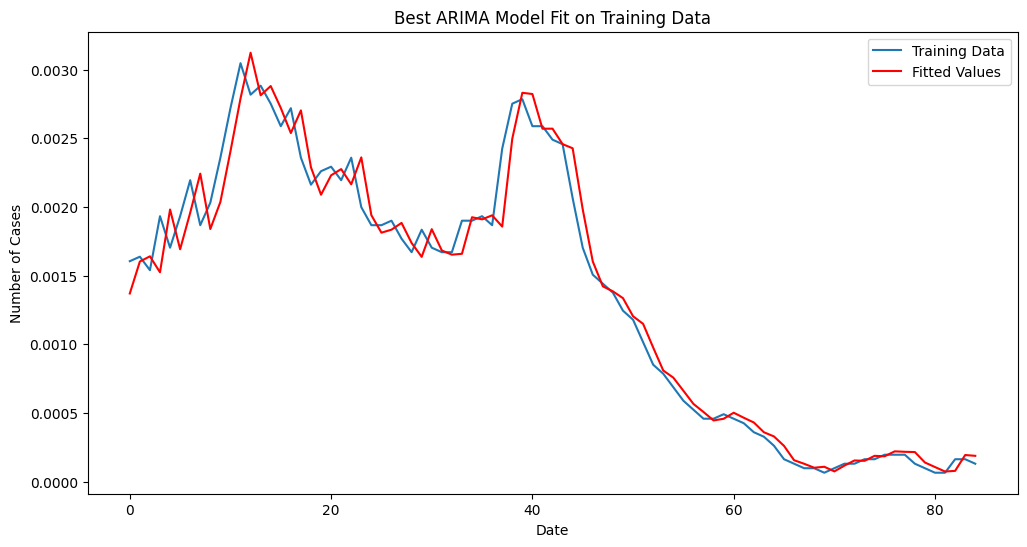

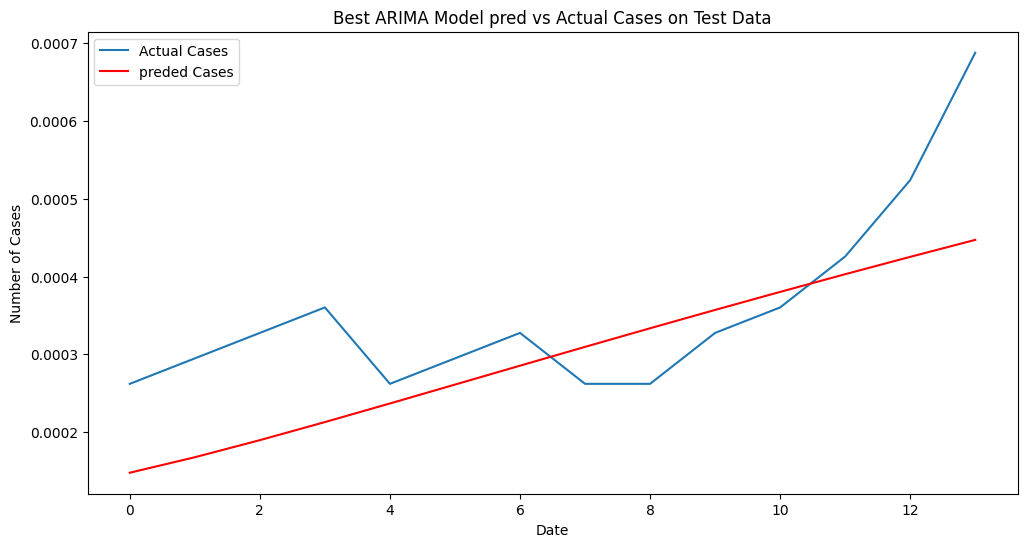

In [14]:
pred = best_model.forecast(steps=len(test))

# Visualize the model fit on training data
plt.figure(figsize=(12, 6))
plt.plot(np.arange(len(train)), train, label='Training Data')
plt.plot(np.arange(len(train)), best_model.fittedvalues, color='red', label='Fitted Values')
plt.title('Best ARIMA Model Fit on Training Data')
plt.xlabel('Date')
plt.ylabel('Number of Cases')
plt.legend()
plt.show()

# Visualize the pred on test data
plt.figure(figsize=(12, 6))
plt.plot(np.arange(len(test)), test, label='Actual Cases')
plt.plot(np.arange(len(pred)), pred, label='preded Cases', color='red')
plt.title('Best ARIMA Model pred vs Actual Cases on Test Data')
plt.xlabel('Date')
plt.ylabel('Number of Cases')
plt.legend()
plt.show()

In [15]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error

# Calculate MAPE
mape = mean_absolute_percentage_error(test, pred)
print(f"Mean Absolute Percentage Error (MAPE): {mape}")

# Calculate MAE
mae = mean_absolute_error(test, pred)
print(f"Mean Absolute Error (MAE): {mae}")

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test, pred))
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Calculate R²
r2 = r2_score(test, pred)
print(f"R-squared (R²): {r2}")

Mean Absolute Percentage Error (MAPE): 0.230632347427732
Mean Absolute Error (MAE): 8.27782449934386e-05
Root Mean Squared Error (RMSE): 0.00010366228073475737
R-squared (R²): 0.2022893805941769
